## Classification Project


* Goal:

        ** Discover drivers of churn based off select cartegories present in the telco dataset
        ** Model and test to verify which modeling style works best and gives us a most favorable outcome

# Imports

In [1]:
# All the imports
import acquire as a
import prepare as p
# tabular manipulation
import numpy as np
import pandas as pd
# ML stuff:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, \
export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Acquire

* Data acquired from CodeUp MySQL server
* It contained 7043 rows and 23 columns before cleaning
* Each column represents tracked customer data

In [2]:
#obtaining data
telco = a.get_telco_data()

this file exists, reading from csv


# Prepare

**Prepare Actions:**
* Removed columns that did not contain useful information
* Renamed columns to promote readability
* Checked for nulls and invalid types in the data
* Checked that column data types were appropriate
* Removed white space from values in object columns
* Added Target column 'churn' indicating whether our selected categories have significance influence
* Encoded categorical variables
* Split data into train, validate and test (approx. 60/40 then 50/50), stratifying on 'churn'
* Scaled continuous variable
* Outliers have not been removed for this iteration of the project

In [3]:
#prepping the data
telco = p.prep_telco(telco)

#adjusting for monthly_charges having invalid data types
telco.monthly_charges.isna()

#fixing the internet service type column
telco['internet_service_type'] = telco['internet_service_type'].fillna('None')

# replaces values in the total charges column with a blank space to 0.0
telco.total_charges = telco.total_charges.str.replace(' ','0.0')

# changes total_charges to a float instead of an object
telco['total_charges'] = (telco.total_charges + '0').astype(float)

#splitting data into train/val/test
telco_train, telco_val, telco_test = p.splitting_data(telco, 'churn')

#encoding split data so that we can use encoded columns with binary outputs
train_encode, val_encode, test_encode = p.preprocess_telco(telco_train,telco_val,telco_test)

#fixing the customer id column for modeling later
train_encode = train_encode.set_index(['customer_id'])
val_encode = val_encode.set_index(['customer_id'])
test_encode = test_encode.set_index(['customer_id'])

#X and y values for train
X_train, y_train = train_encode.drop(columns='churn_Yes'), \
train_encode.churn_Yes

#X and y values for validate
X_val, y_val = val_encode.drop(columns='churn_Yes'), \
val_encode.churn_Yes

#X and y values for test
X_test, y_test = test_encode.drop(columns='churn_Yes'), \
test_encode.churn_Yes

## Quick look at what our data looks like and summary

In [4]:
train_encode.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,,,,,,,,,,,,,
8775-CEBBJ,0,9,44,403.35,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
0336-KXKFK,0,72,61,4390.25,1,0,0,0,1,0,...,1,1,0,0,1,0,0,1,0,0
1383-EZRWL,0,7,20,164.85,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
0311-UNPFF,0,26,88,2274.35,0,0,0,1,0,0,...,1,1,1,0,0,1,0,0,0,0
3640-PHQXK,0,31,89,2806.90,0,0,0,1,0,1,...,1,1,1,0,0,1,0,0,1,0


In [5]:
train_encode.dtypes

senior_citizen                             int64
tenure                                     int64
monthly_charges                            int64
total_charges                            float64
gender_Male                                int64
partner_Yes                                int64
dependents_Yes                             int64
phone_service_Yes                          int64
multiple_lines_No phone service            int64
multiple_lines_Yes                         int64
online_security_No internet service        int64
online_security_Yes                        int64
online_backup_No internet service          int64
online_backup_Yes                          int64
device_protection_No internet service      int64
device_protection_Yes                      int64
tech_support_No internet service           int64
tech_support_Yes                           int64
streaming_tv_No internet service           int64
streaming_tv_Yes                           int64
streaming_movies_No 

In [20]:
train_encode.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4225 entries, 8775-CEBBJ to 1078-TDCRN
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   senior_citizen                         4225 non-null   int64  
 1   tenure                                 4225 non-null   int64  
 2   monthly_charges                        4225 non-null   int64  
 3   total_charges                          4225 non-null   float64
 4   gender_Male                            4225 non-null   int64  
 5   partner_Yes                            4225 non-null   int64  
 6   dependents_Yes                         4225 non-null   int64  
 7   phone_service_Yes                      4225 non-null   int64  
 8   multiple_lines_No phone service        4225 non-null   int64  
 9   multiple_lines_Yes                     4225 non-null   int64  
 10  online_security_No internet service    4225 non-null   int64  

## EXPLORE

In [6]:
#Understanding baseline and setting alpha
baseline_percentage = (telco.churn == "No").mean()
print(f'The baseline of churn is {baseline_percentage}')
#setting the alpha
α = 0.05

The baseline of churn is 0.7346301292063041


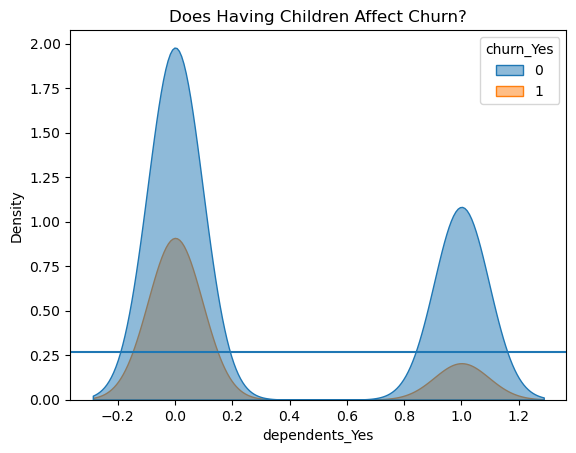

In [7]:
sns.kdeplot(data=train_encode, x='dependents_Yes', hue='churn_Yes', fill=True, alpha=.5)
plt.title("Does Having Children Affect Churn?")
population_churn = train_encode.churn_Yes.mean()
plt.axhline(population_churn, label="Population Churn Rate")
plt.show()

> Onto the statistical tests, utilizing chi^2 tests for these features since they're all bivariate 

In [8]:
# Let's run a chi squared to compare proportions, to have more confidence
𝐻0  = "there is NO relationship between gender and churn"
𝐻𝑎  = "there is a relationship between gender and churn"

# Setup a crosstab of observed survival to pclass
observed_gender = pd.crosstab(train_encode.churn_Yes, train_encode.gender_Male)

chi2, p, degf, expected = stats.chi2_contingency(observed_gender)

if p < α:
    print(f"Reject the null hypothesis that, {𝐻0}")
    print(f"Sufficient evidence to move forward understanding that, {𝐻𝑎}")
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Fail to reject the null
Insufficient evidence to reject the null


0.34677390607565795

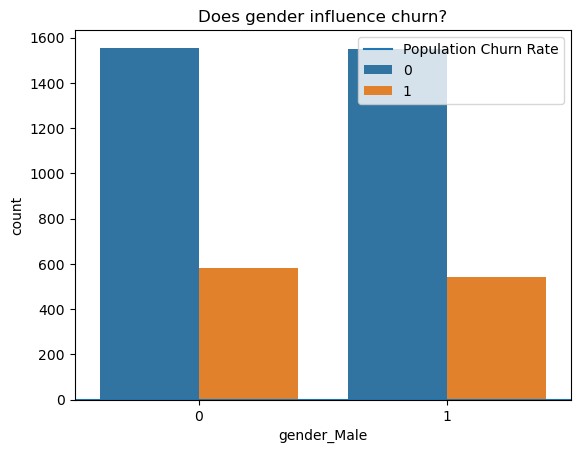

In [9]:
#building plots for my selected features
sns.countplot(data=train_encode, x='gender_Male', hue='churn_Yes')
plt.title("Does gender influence churn?")
plt.axhline(population_churn, label="Population Churn Rate")
plt.legend()
plt.show()

Gender not appearing to influence churn

In [10]:
𝐻0  = "there is NO relationship between having a partner and churn"
𝐻𝑎  = "there is a relationship between having a parnter and churn"

# Setup a crosstab of observed survival to pclass
observed_partner = pd.crosstab(train_encode.churn_Yes, train_encode.partner_Yes)

chi2, p, degf, expected = stats.chi2_contingency(observed_partner)

if p < α:
    print(f"Reject the null hypothesis that, {𝐻0}")
    print(f"Sufficient evidence to move forward understanding that, {𝐻𝑎}")
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that, there is NO relationship between having a partner and churn
Sufficient evidence to move forward understanding that, there is a relationship between having a parnter and churn


3.3117883244850396e-24

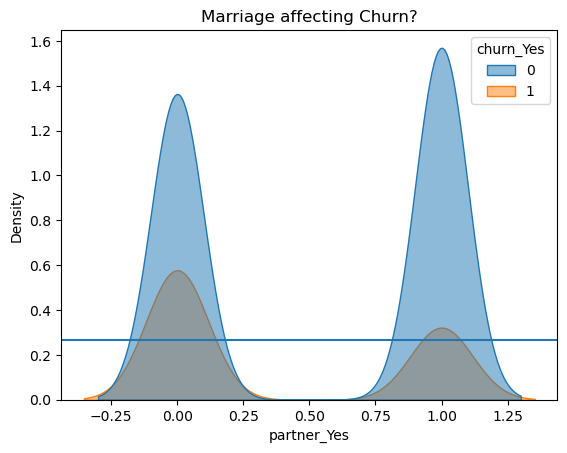

In [11]:
sns.kdeplot(data=train_encode, x='partner_Yes', hue='churn_Yes', fill=True, alpha=.5)
plt.title("Marriage affecting Churn?")
plt.axhline(population_churn, label="Population Churn Rate")
plt.show()

Partner is observed to influence churn

In [12]:
𝐻0 = "there is NO relationship between having dependents and churn"
𝐻𝑎 = "there is a relationship between having dependents and churn"

# Setup a crosstab of observed survival to pclass
observed_dependents = pd.crosstab(train_encode.churn_Yes, train_encode.dependents_Yes)

chi2, p, degf, expected = stats.chi2_contingency(observed_dependents)

if p < α:
    print(f"Reject the null hypothesis that, {𝐻0}")
    print(f"Sufficient evidence to move forward understanding that, {𝐻𝑎}")
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that, there is NO relationship between having dependents and churn
Sufficient evidence to move forward understanding that, there is a relationship between having dependents and churn


6.84215803296947e-26

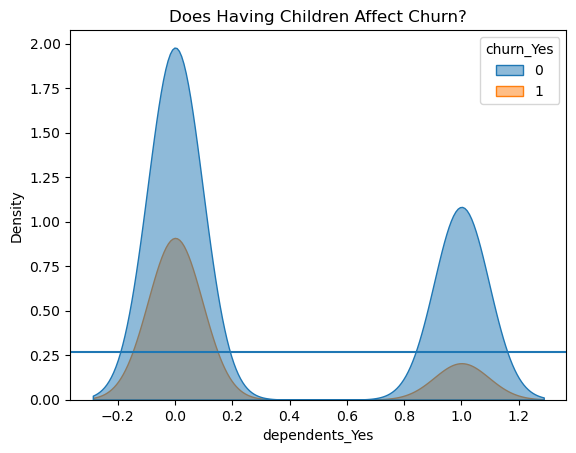

In [13]:
sns.kdeplot(data=train_encode, x='dependents_Yes', hue='churn_Yes', fill=True, alpha=.5)
plt.title("Does Having Children Affect Churn?")
plt.axhline(population_churn, label="Population Churn Rate")
plt.show()

Having children is observed to affect churn

In [14]:
null_hypothesis = "there is NO relationship between paperless billing and churn"
alternative_hypothesis = "there is a relationship between paperless billing and churn"

# Setup a crosstab of observed survival to pclass
observed_paper = pd.crosstab(train_encode.churn_Yes, train_encode.paperless_billing_Yes)

chi2, p, degf, expected = stats.chi2_contingency(observed_paper)

if p < α:
    print(f"Reject the null hypothesis that, {null_hypothesis}")
    print(f"Sufficient evidence to move forward understanding that, {alternative_hypothesis}")
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that, there is NO relationship between paperless billing and churn
Sufficient evidence to move forward understanding that, there is a relationship between paperless billing and churn


5.802667394637569e-38

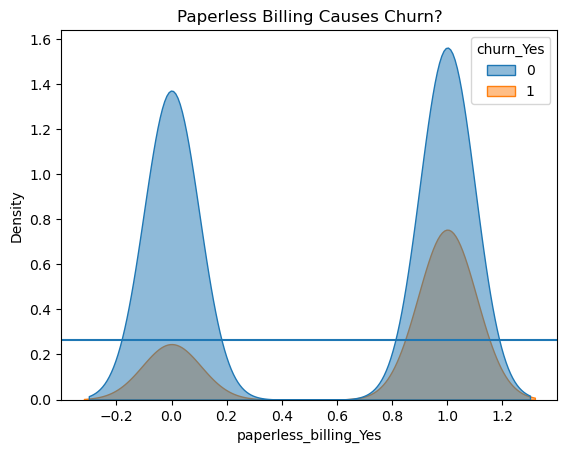

In [15]:
sns.kdeplot(data=train_encode, x='paperless_billing_Yes', hue='churn_Yes', fill=True, alpha=.5)
#plt.title("Does Having Children Affect Churn?")
plt.axhline(population_churn, label="Population Churn Rate")
plt.title("Paperless Billing Causes Churn?")
plt.show()

Paperless billing is observed to have an effect on churn

# Exploration Summary

* Paperless billing, children, and marriage all have a signifcant effect on churn while gender shows relatively little variance in churn rates

# Modeling

In [16]:
# DECISION TREE
#create the decision tree object
tree_2 = DecisionTreeClassifier(max_depth=2, random_state=24)

#fit the object only on TRAIN DATA!
tree_2.fit(X_train, y_train)

#calculate the accuracy for train and validate
acc_train_tree = tree_2.score(X_train, y_train)
acc_validate_tree = tree_2.score(X_val, y_val)

print(f'max depth of 2, the accuracy on train = {round(acc_train_tree,4)}, on val = {round(acc_validate_tree,4)}')

max depth of 2, the accuracy on train = 0.7922, on val = 0.7906


Decision tree gives us a favorable model to use however, 

In [17]:
#RANDOM FOREST
# Create the RandomForestClassifier object
forest_5 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=24)
    
# Fit the model on the training data
forest_5.fit(X_train, y_train)
    
# Calculate the accuracy
acc_forest = forest_5.score(X_train, y_train)
acc_forest_val = forest_5.score(X_val, y_val)

print(f'max depth of 5, the accuracy train = {round(acc_forest,4)}, val = {round(acc_forest_val,4)}')

max depth of 5, the accuracy train = 0.8026, val = 0.7999


Random forest provides an even better model which is the one we will use for our test data

In [18]:
#LOGISTIC REGRESSION
# Create the LogisticRegression object
lr = LogisticRegression()
features = ['partner_Yes', 'dependents_Yes', 'paperless_billing_Yes']
#fit it
lr.fit(X_train[features], y_train)
lr.score(X_train[features], y_train)

0.7346745562130178

Logisitic Regression is barely performing above baseline

In [19]:
#after deciding best test, create a variable, fit it, and then test it
forest_5 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=24)
forest_5.fit(X_train, y_train)
forest_5.score(X_test,y_test)

0.7913413768630234

### Modeling Summary

* Logistic Regression model performed about equal to baseline on train and validate
* The Decision Tree and Random Forest models performed quite close to one another with a slight advantage in percentage accuracy going to the Random Forest
* A Random Forest model selected as the final model and had an accuracy of about 78.9% which is about 5% better than the baseline accuracy without the model becoming too overfit

# Conclusions

### Exploration

* Factors of churn at Telco vary from all sorts of categories
* Paperless Billing, Having Dependents, and Having a Partner all have an effect on churn while factors like Gender do not influence churn much
* The final model slightly predicts better than baseline but not by a signifcant margin
### Recommendations

* Possibly change categories to see if other factors play a larger role in churn

### Next Steps
* Continue investigating additional data for more clues on churn rates
* Develop strategies to incentivize less churn based on columns that produce low churn rates